In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn import naive_bayes, linear_model, svm
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import TransformerMixin, BaseEstimator 
from utilities import percent_survivor, one_hot_encoder
%matplotlib inline

In [2]:
test_df = pd.read_csv('test.csv')
answers = pd.read_csv('answers.csv')
train_df = pd.read_csv('train.csv')
df = train_df.copy()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.Survived.value_counts()/df.shape[0]

0    0.616162
1    0.383838
Name: Survived, dtype: float64

## __Data Cleanup and EDA:__

In [4]:
# TransformerMixin enables inheritance of fit_transform() 
# and BaseEstimator inherits get_params() and set_params()
# Although these are not needed for execution but they 
# are needed to build a sklearn pipeline.

class TitleExtractor(BaseEstimator, TransformerMixin):
    """Extracts the title from the given names. Further, classifies each 
    title into five unique titles: Mr, Mrs, Miss, Master, and Others."""
    def __init__(self):
        pass
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        title_dict = {'Miss': ['Ms', 'Mlle'],
                      'Mrs': ['Mme'],
                      'Others':['Lady', 'the Countess', 'Jonkheer', 'Dona', 
                                'Rev', 'Sir','Capt', 'Col', 'Major', 'Don', 'Dr']} 
        df.loc[:,'Title'] = df.Name.apply(lambda x: re.match(pattern='.+, (.+?)\..+', string=x)[1])
        for key, values in title_dict.items():
            df.Title.replace(values, key, inplace=True)
        return df

In [5]:
obj = TitleExtractor()
obj.fit_transform(df)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [6]:
df.Title.value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Others     23
Name: Title, dtype: int64

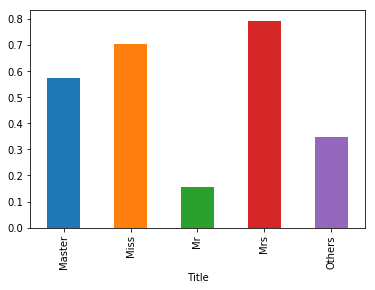

In [7]:
percent_survivor(df, 'Title').plot(kind='bar')

It's clear that older males (Mr) have a very low rate of survival.
In "royalty" and "others", there could be several women who are not accounted for. 
So this is feature is unlikely to be a major factor for determining survival.

__Calculating missing ages based on title:__

In [8]:
df.Age.isnull().value_counts()

False    714
True     177
Name: Age, dtype: int64

In [9]:
class MissingValues(BaseEstimator, TransformerMixin):
    """Average age of the population with the same title
    is used to compute the age of the missing person."""
    def __init__(self):
        pass
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        title_mean_age = {}
        for i in df.Title.unique(): title_mean_age[i] = df[df['Title']==i].Age.mean()
        df.loc[df.Age.isnull(),'Age'] = df.loc[df.Age.isnull(),'Title'].apply(lambda x: title_mean_age[x])
        df.loc[df.Fare.isnull(),'Fare']=9 #Only 1 such instance so putting a value of 9
        df.loc[df.Embarked.isnull(),'Embarked'] = 'S' # Only 2 missing values so using a random value of "S"
        return df

In [10]:
obj = MissingValues()
obj.fit_transform(df)
df[df.Age.isnull()].shape

(0, 13)

In [11]:
df.loc[:,'Age_Range'] = pd.cut(df.Age, bins=np.append([0,12,25,35,45], float('inf')))

In [12]:
df.Age_Range.value_counts()

(25.0, 35.0]    315
(12.0, 25.0]    268
(35.0, 45.0]    131
(45.0, inf]     104
(0.0, 12.0]      73
Name: Age_Range, dtype: int64

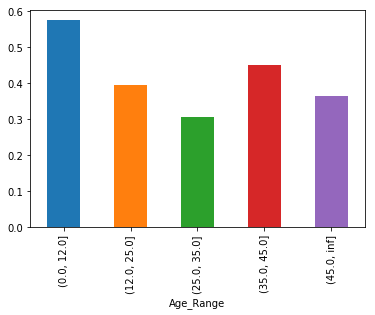

In [13]:
percent_survivor(df, 'Age_Range').plot(kind='bar')

The above chart shows children having a higher rate of survival then people of other age ranges.

In [14]:
class FamilySize(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df.loc[:,'family_size'] = df.SibSp + df.Parch
        return df

In [15]:
obj = FamilySize()
obj.fit_transform(df)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_Range,family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,"(12.0, 25.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,"(35.0, 45.0]",1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,"(25.0, 35.0]",0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,"(25.0, 35.0]",1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,"(25.0, 35.0]",0


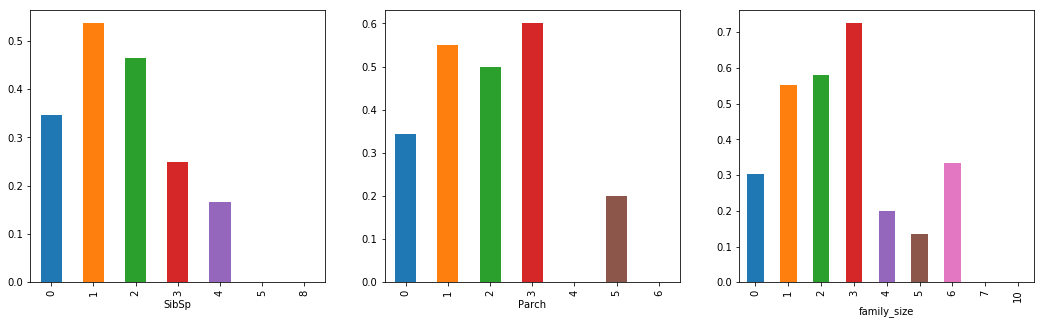

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
percent_survivor(df, 'SibSp').plot(kind='bar', ax=axes[0])
percent_survivor(df, 'Parch').plot(kind='bar', ax=axes[1])
percent_survivor(df, 'family_size').plot(kind='bar', ax=axes[2])

Overall family size of 3 implies the highest rates of survival.

In [17]:
df.Ticket.nunique()

681

Too many unique ID's to make any sense of this.

In [18]:
df.Sex.value_counts(dropna=False)

male      577
female    314
Name: Sex, dtype: int64

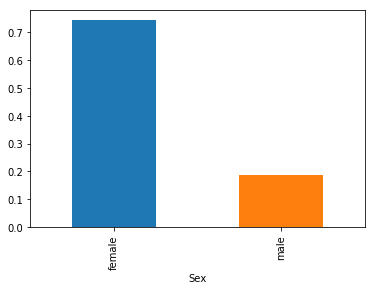

In [19]:
percent_survivor(df,'Sex').plot(kind='bar')

In [20]:
class GenderEncoding(BaseEstimator, TransformerMixin):
    """Males represented by 0 and Females by 1"""
    def __init__(self):
        pass
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df.Sex.replace({'male': 0, 'female': 1}, inplace=True)
        return df

In [21]:
obj = GenderEncoding()
obj.fit_transform(df)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_Range,family_size
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,"(12.0, 25.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,"(35.0, 45.0]",1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,"(25.0, 35.0]",0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,Mrs,"(25.0, 35.0]",1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,Mr,"(25.0, 35.0]",0


In [22]:
df.Pclass.value_counts(dropna=False)

3    491
1    216
2    184
Name: Pclass, dtype: int64

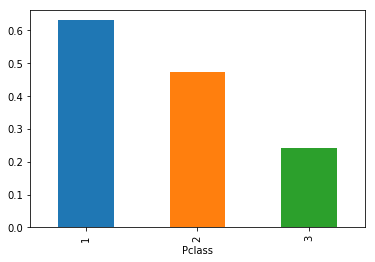

In [23]:
percent_survivor(df, 'Pclass').plot(kind='bar')

First class passengers had a higher rate of survival.

In [24]:
class MakeCategorical(BaseEstimator, TransformerMixin):
    """Pass the column name as an argument and convert
    the column from numerical to categorical."""
    def __init__(self, key=None):
        self.key = key
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df[self.key].replace({1:'first',2:'second',3:'third'}, inplace=True)
        return df

In [25]:
obj = MakeCategorical('Pclass')
obj.fit_transform(df)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_Range,family_size
0,1,0,third,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,"(12.0, 25.0]",1
1,2,1,first,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,"(35.0, 45.0]",1
2,3,1,third,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,"(25.0, 35.0]",0
3,4,1,first,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,Mrs,"(25.0, 35.0]",1
4,5,0,third,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,Mr,"(25.0, 35.0]",0


In [26]:
df.Cabin.value_counts(dropna=False).head()

NaN            687
G6               4
B96 B98          4
C23 C25 C27      4
E101             3
Name: Cabin, dtype: int64

Too many null values to make any sense out of it.

In [27]:
df.Embarked.value_counts(dropna=False)

S    646
C    168
Q     77
Name: Embarked, dtype: int64

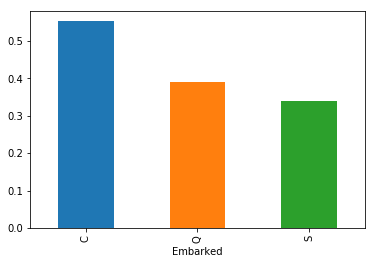

In [28]:
percent_survivor(df, 'Embarked').plot(kind='bar')

People embarking at C had a higher rate of survival.

In [29]:
df.loc[:,'fare_range'] = pd.cut(df.Fare, bins=np.append([0,10,25,50,100,200], float('inf')))

In [30]:
df.fare_range.value_counts()

(0.0, 10.0]       321
(10.0, 25.0]      221
(25.0, 50.0]      174
(50.0, 100.0]     107
(100.0, 200.0]     33
(200.0, inf]       20
Name: fare_range, dtype: int64

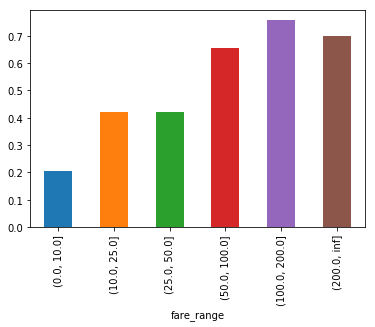

In [31]:
percent_survivor(df, 'fare_range').plot(kind='bar')

People who paid lower fares have a much lower chance of survival.

In [32]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_Range,family_size,fare_range
0,1,0,third,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,"(12.0, 25.0]",1,"(0.0, 10.0]"
1,2,1,first,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,"(35.0, 45.0]",1,"(50.0, 100.0]"
2,3,1,third,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,"(25.0, 35.0]",0,"(0.0, 10.0]"
3,4,1,first,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,Mrs,"(25.0, 35.0]",1,"(50.0, 100.0]"
4,5,0,third,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,Mr,"(25.0, 35.0]",0,"(0.0, 10.0]"


In [33]:
class FeatureCreation(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df, y=None):
        return self
    def transform(self, df, y=None):
        x = df[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Title','family_size']]
        for i in ['Pclass', 'Embarked','Title']:
            x = one_hot_encoder(x, i)
        return x

In [34]:
obj = FeatureCreation()

In [35]:
x, y = obj.fit_transform(df), df.Survived.values

In [36]:
x.head()

,Sex,Age,SibSp,Parch,Fare,family_size,Pclass_third,Pclass_first,Pclass_second,Embarked_S,Embarked_C,Embarked_Q,Title_Mr,Title_Mrs,Title_Miss,Title_Master,Title_Others
0,0,22.0,1,0,7.2500,1,1,0,0,1,0,0,1,0,0,0,0
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0,1,0,0,0
2,1,26.0,0,0,7.9250,0,1,0,0,1,0,0,0,0,1,0,0
3,1,35.0,1,0,53.1000,1,0,1,0,1,0,0,0,1,0,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1,0,0,0,0


In [37]:
x = MinMaxScaler().fit_transform(x)

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [38]:
n = np.arange(5, x.shape[1])
evr = []
for i in n:
    pca = PCA(n_components=i)
    pca.fit(x)
    evr.append(pca.explained_variance_ratio_.sum())

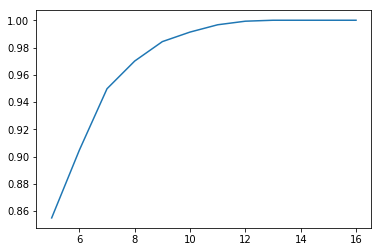

In [39]:
plt.plot(n,evr)

In [40]:
pca = PCA(n_components=10)

In [41]:
x = pca.fit_transform(x)

In [42]:
clf = GridSearchCV(RandomForestClassifier(class_weight='balanced'),cv=10, param_grid = {'n_estimators':[100,500], 
                                                                                        'min_samples_leaf':[40,50,70]})

In [43]:
clf.fit(x, df.Survived.values)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 500], 'min_samples_leaf': [40, 50, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [44]:
clf.best_params_

{'min_samples_leaf': 40, 'n_estimators': 500}

In [45]:
pipe = make_pipeline(TitleExtractor(), MissingValues(), FamilySize(), GenderEncoding(), 
                     MakeCategorical('Pclass'), FeatureCreation(), MinMaxScaler(), PCA(),
                     RandomForestClassifier(n_estimators=500, min_samples_leaf=40))

In [46]:
pipe.fit(train_df.copy(), train_df.Survived.values)

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Pipeline(memory=None,
     steps=[('titleextractor', TitleExtractor()), ('missingvalues', MissingValues()), ('familysize', FamilySize()), ('genderencoding', GenderEncoding()), ('makecategorical', MakeCategorical(key='Pclass')), ('featurecreation', FeatureCreation()), ('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [47]:
pipe.score(train_df.copy(), train_df.Survived.values)

0.8372615039281706

In [48]:
pipe.score(test_df.copy(), answers.Survived.values)

0.7440191387559809

In [49]:
confusion_matrix = pd.crosstab(pd.Series(pipe.predict(test_df.copy()), name='Predicted'), 
                               pd.Series(answers.Survived.values, name='Actual'))

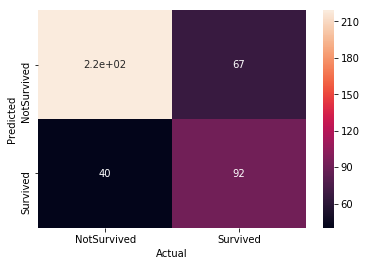

In [50]:
import seaborn as sns
labels = ['NotSurvived','Survived']
sns.heatmap(confusion_matrix, annot=True, xticklabels = labels, yticklabels=labels)

In [52]:
import pickle

In [53]:
with open('titanic_pipeline.pickle', 'w') as f:
    pickle.dump(pipe, f)

TypeError: write() argument must be str, not bytes